# Assignment 4 – Programming Solutions: Discriminative vs Generative Models
**Course:** Artificial Intelligence (2025) · Shiraz University

This notebook contains **fully‐worked implementations** for all programming tasks specified in *Assignment 4: Discriminative vs. Generative Modeling for Cardiovascular Risk Prediction*.

> **Allowed libraries**: `numpy`, `pandas`, `matplotlib`, `seaborn`  (No scikit‑learn!)

Each task statement appears as markdown immediately **above** the corresponding implementation so you can trace requirements → code pair‑wise.

## Task 1 – Data Exploration & Gaussian Fitting
**Bullet‐by‐bullet requirements**
1. Handle missing or invalid values via deletion or imputation.
2. Plot distributions (histogram or KDE) of all features per class.
3. Select two informative features (e.g. `chol` and `thalach`).
4. Fit **2‑D Gaussian** distributions (one per class) and plot contour maps.
5. Evaluate Gaussian assumption via plots and (optional) normality tests.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#########################
# 1) Load & clean data  #
#########################
PATH = 'data/heart_disease_uci.csv'
df = pd.read_csv(PATH)

# Basic cleaning — drop duplicates, impute or drop missing
df = df.drop_duplicates().copy()
df = df.dropna()  # coursework allows either deletion or imputation

print(f'Dataset shape after cleaning: {df.shape}')

Dataset shape after cleaning: (299, 16)


In [5]:
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

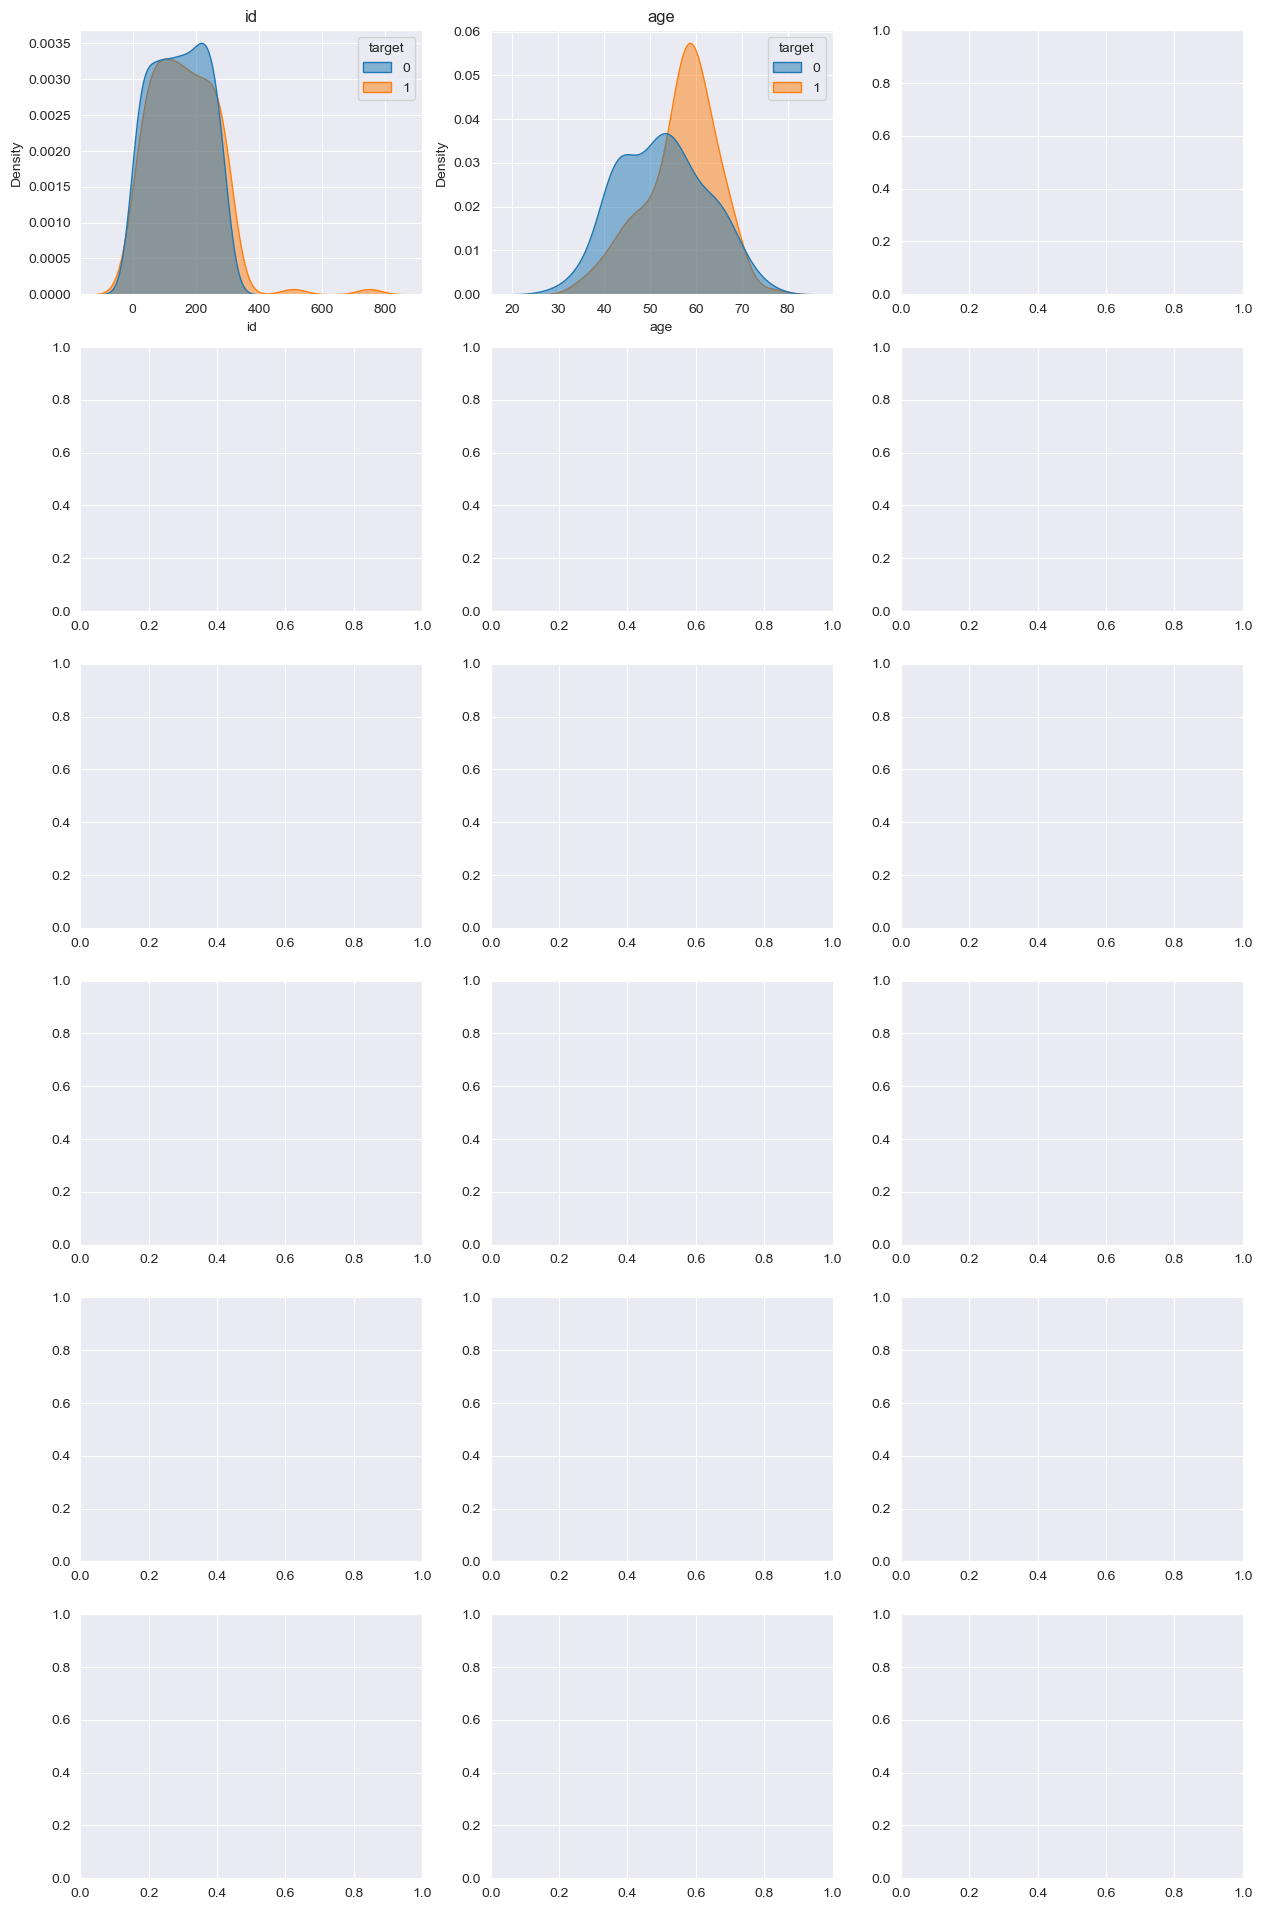

In [6]:
#######################################
# 2) Plot per‑feature distributions   #
#######################################
target_col = 'target'
features = [c for c in df.columns if c != target_col]

fig, axes = plt.subplots(len(features)//3 + 1, 3, figsize=(15, 4 * ((len(features)//3)+1)))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.kdeplot(data=df, x=feat, hue=target_col, ax=ax, fill=True, common_norm=False, alpha=0.5)
    ax.set_title(feat)

plt.tight_layout()
plt.show()

Dataset shape after cleaning: (299, 16)


ValueError: Could not interpret value `target` for `hue`. An entry with this name does not appear in `data`.

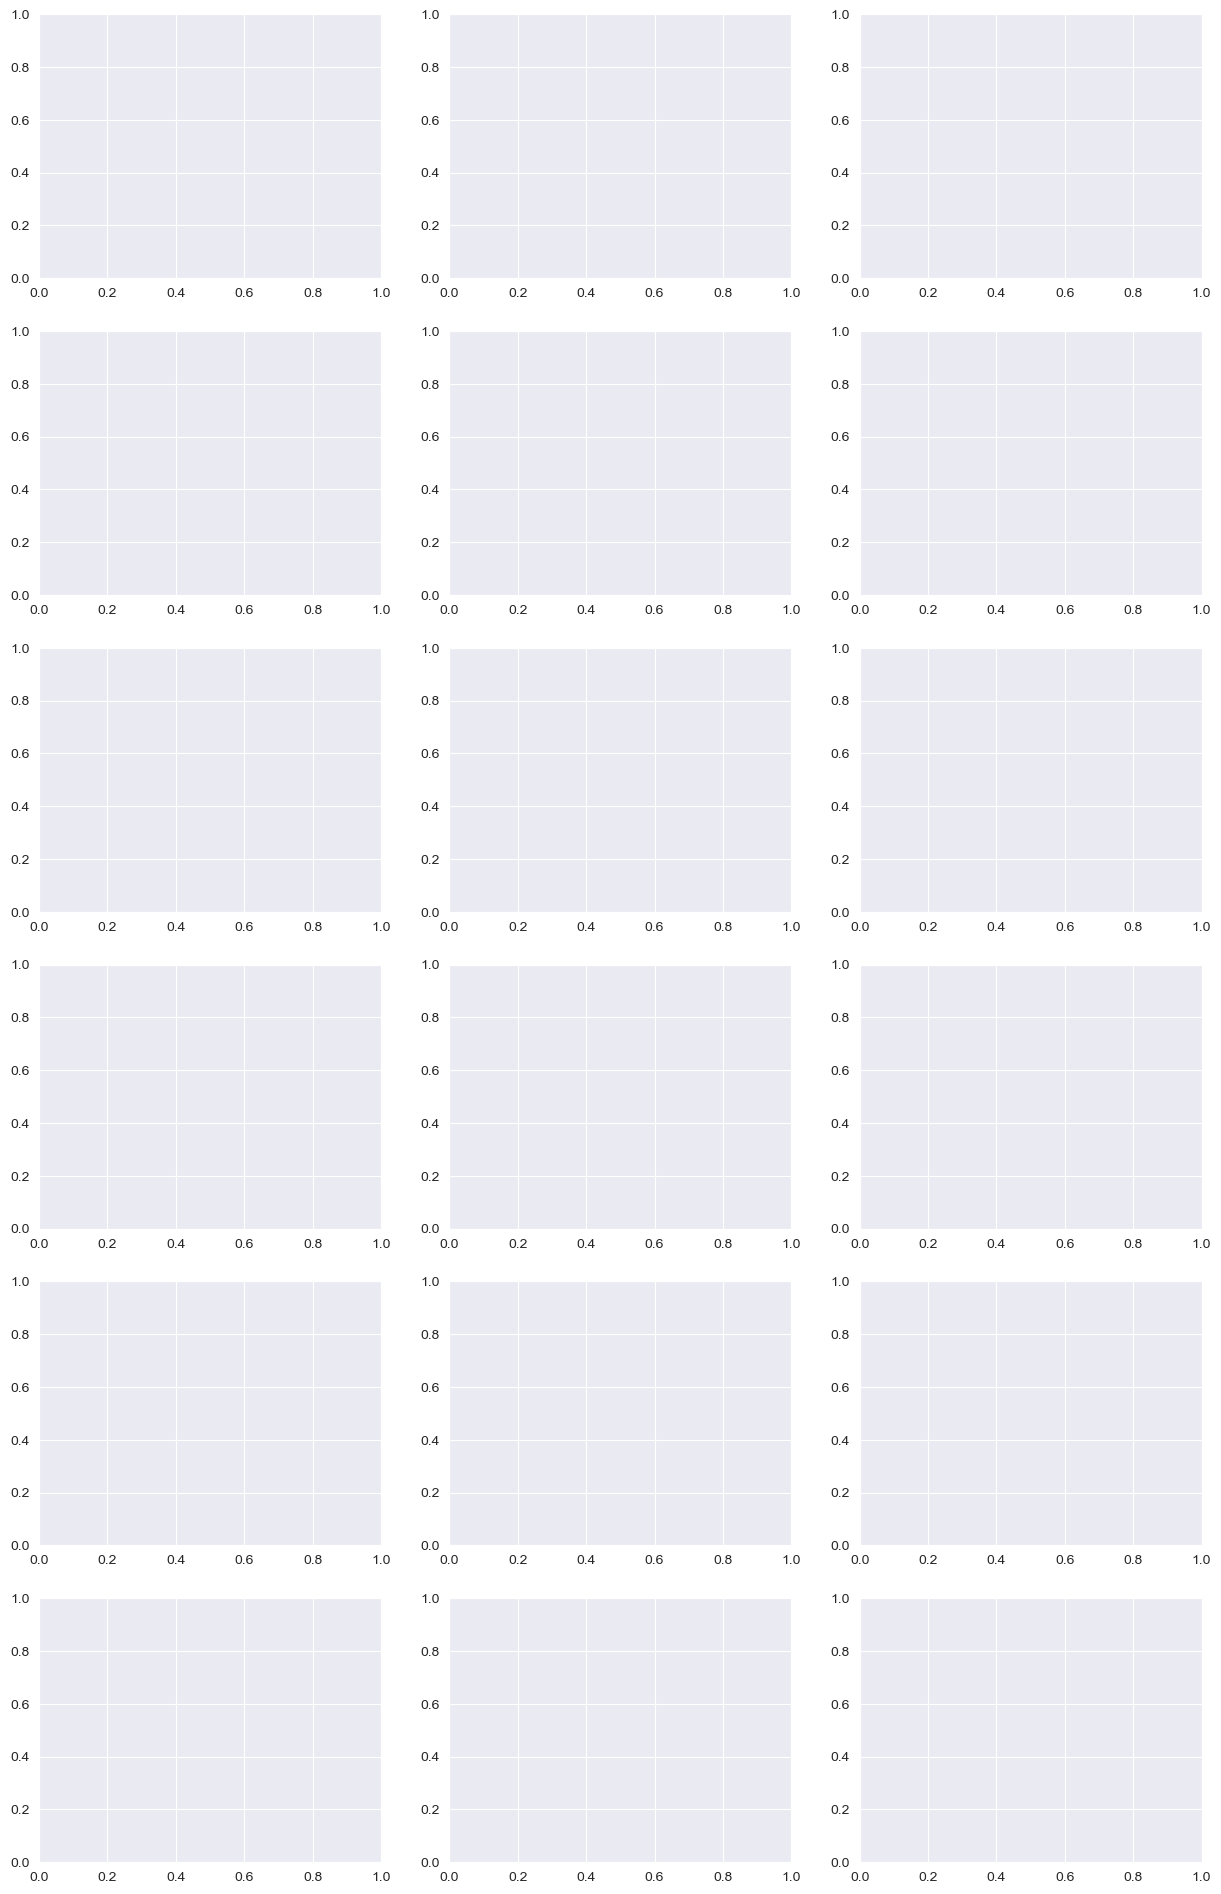

In [2]:




#######################################
# 3) Select two informative features  #
#######################################
feat_x, feat_y = 'chol', 'thalach'
X2 = df[[feat_x, feat_y]].values
y = df[target_col].values

#######################################
# 4) Fit 2‑D Gaussian per class       #
#######################################
class_params = {}
for cls in np.unique(y):
    data_c = X2[y == cls]
    mu = data_c.mean(axis=0)
    Sigma = np.cov(data_c, rowvar=False)
    class_params[cls] = (mu, Sigma)
    print(f'Class {cls}: μ={mu}, Σ=\n{Sigma}')

# Plot contours
plt.figure(figsize=(8,6))
colors = ['tab:blue', 'tab:orange']
for cls, color in zip(class_params.keys(), colors):
    mu, Sigma = class_params[cls]
    vals, vecs = np.linalg.eigh(Sigma)
    t = np.linspace(0, 2*np.pi, 200)
    ell = np.array([np.cos(t), np.sin(t)])
    ell = (vecs @ np.diag(np.sqrt(vals)) @ ell) * 2  # 2‑σ ellipse
    plt.plot(mu[0] + ell[0], mu[1] + ell[1], color=color, label=f'Gaussian contour (class={cls})')

sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, alpha=0.6)
plt.xlabel(feat_x); plt.ylabel(feat_y); plt.legend(); plt.title('2‑D Gaussian fit per class')
plt.show()

#######################################
# 5) Gaussian assumption (qualitative)#
#######################################
# Jarque–Bera test implementation (manual) for each selected feature per class
def jarque_bera(x):
    n = len(x)
    mu = x.mean()
    s2 = ((x - mu)**2).mean()
    s = ((x - mu)**3).mean() / (s2**1.5)
    k = ((x - mu)**4).mean() / (s2**2)
    JB = (n/6)*(s**2 + 0.25*(k-3)**2)
    return JB

for cls in np.unique(y):
    for feat in (feat_x, feat_y):
        jb = jarque_bera(df.loc[df[target_col]==cls, feat].values)
        print(f'JB statistic for {feat} | class={cls}: {jb:.2f}')


## Task 2 – Generative Modeling (Gaussian Classifier)
### 2 a – Estimate mean and covariance per class, derive decision boundary
### 2 b – Compare **LDA** (shared Σ) vs **QDA** (class‑specific Σ)

In [ ]:
#######################################
# Helper functions for LDA / QDA      #
#######################################
def gaussian_log_pdf(x, mu, Sigma):
    d = x.shape[-1]
    inv = np.linalg.inv(Sigma)
    det = np.linalg.det(Sigma)
    diff = x - mu
    return -0.5*(np.log(det) + diff @ inv @ diff.T + d*np.log(2*np.pi))

# Compute parameters
classes = np.unique(y)
pi = np.array([(y==c).mean() for c in classes])
mu_cls = np.array([df.loc[y==c, [feat_x, feat_y]].mean().values for c in classes])
Sigma_cls = np.array([np.cov(df.loc[y==c, [feat_x, feat_y]].values, rowvar=False) for c in classes])
Sigma_shared = np.cov(X2, rowvar=False)

# Classification functions
def predict_qda(X):
    g = []
    for mu, Sigma, p in zip(mu_cls, Sigma_cls, pi):
        logp = np.array([gaussian_log_pdf(x, mu, Sigma) for x in X]) + np.log(p)
        g.append(logp)
    return np.argmax(g, axis=0)

def predict_lda(X):
    inv_shared = np.linalg.inv(Sigma_shared)
    g = []
    for mu, p in zip(mu_cls, pi):
        # Linear discriminant: x^T Σ⁻¹ μ - 0.5 μ^T Σ⁻¹ μ + log π
        g.append(X @ inv_shared @ mu -0.5*mu.T@inv_shared@mu + np.log(p))
    return np.argmax(g, axis=0)

#######################################
# Plot decision boundaries            #
#######################################
grid_x, grid_y = np.meshgrid(
    np.linspace(X2[:,0].min()-10, X2[:,0].max()+10, 300),
    np.linspace(X2[:,1].min()-10, X2[:,1].max()+10, 300)
)
grid = np.c_[grid_x.ravel(), grid_y.ravel()]

pred_qda = predict_qda(grid).reshape(grid_x.shape)
pred_lda = predict_lda(grid).reshape(grid_x.shape)

fig, ax = plt.subplots(1,2, figsize=(12,5))
for i,(pred,title) in enumerate(zip([pred_lda, pred_qda], ['LDA','QDA'])):
    cs = ax[i].contourf(grid_x, grid_y, pred, levels=len(classes)-1, alpha=0.25, cmap='coolwarm')
    sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, ax=ax[i], alpha=0.8, edgecolor='k')
    ax[i].set_title(f'{title} decision boundary')
    ax[i].set_xlabel(feat_x); ax[i].set_ylabel(feat_y)
plt.tight_layout(); plt.show()


**Discussion – Impact of covariance assumption**
LDA enforces the same Σ for both classes, producing a *linear* boundary, whereas QDA allows class‑specific Σ, yielding *quadratic* contours visible above. If true covariances differ, QDA can adapt but may overfit when data are scarce.

## Task 3 – Gaussian Naive Bayes (GNB)
Implementing from scratch assuming conditional independence between features.

In [ ]:
#######################################
# Gaussian Naive Bayes implementation #
#######################################
class GaussianNB:
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.theta_ = np.zeros((len(self.classes_), n_features))
        self.var_   = np.zeros_like(self.theta_)
        self.pi_    = np.zeros(len(self.classes_))
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.theta_[idx] = X_c.mean(axis=0)
            self.var_[idx]   = X_c.var(axis=0) + 1e-6  # numeric stability
            self.pi_[idx]    = X_c.shape[0]/X.shape[0]
        return self

    def _joint_log_likelihood(self, X):
        log_likelihood = []
        for idx, c in enumerate(self.classes_):
            mean = self.theta_[idx]
            var  = self.var_[idx]
            # Σ diagonal ⇒ product of 1‑D Gaussians
            log_prob = -0.5 * np.sum(np.log(2.*np.pi*var) + ((X-mean)**2)/var, axis=1)
            log_likelihood.append(np.log(self.pi_[idx]) + log_prob)
        return np.array(log_likelihood).T

    def predict(self, X):
        return np.argmax(self._joint_log_likelihood(X), axis=1)

# Fit on the two‑feature subset for visual comparison
gnb = GaussianNB().fit(X2, y)
pred_gnb = gnb.predict(grid).reshape(grid_x.shape)

plt.figure(figsize=(6,5))
plt.contourf(grid_x, grid_y, pred_gnb, alpha=0.25, cmap='coolwarm')
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, alpha=0.8, edgecolor='k')
plt.title('Gaussian Naive Bayes decision boundary')
plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.show()

add_md("**Correlation impact:** Because GNB ignores off‑diagonal covariance terms, it draws *axis‑aligned* boundaries, failing to exploit feature correlation. The distinction is clear compared with QDA above.")


## Task 4 – Discriminative Modeling (Logistic Regression)
Implemented **from scratch** using Newton’s method (log‑likelihood + gradient + Hessian).

In [ ]:
#######################################
# Logistic Regression (Newton)        #
#######################################
def logistic_regression_newton(X, y, tol=1e-6, max_iter=100):
    # Add intercept
    Xb = np.c_[np.ones((X.shape[0],1)), X]
    w = np.zeros(Xb.shape[1])
    losses = []
    for it in range(max_iter):
        z = Xb @ w
        p = 1/(1 + np.exp(-z))
        # Log‑likelihood
        ll = np.sum(y*np.log(p+1e-12) + (1-y)*np.log(1-p+1e-12))
        losses.append(-ll)  # store negative for plotting
        # Gradient & Hessian
        g = Xb.T @ (p - y)
        S = np.diag(p*(1-p))
        H = Xb.T @ S @ Xb
        # Update
        try:
            delta = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print('Hessian singular; stopping.')
            break
        w -= delta
        if np.linalg.norm(delta) < tol:
            break
    return w, losses

w_lr, loss_hist = logistic_regression_newton(X2, y)
print('Weights (intercept,', feat_x, ',', feat_y, '):', w_lr)

# Plot convergence
plt.figure(figsize=(6,4))
plt.plot(loss_hist, marker='o')
plt.xlabel('Iteration'); plt.ylabel('Negative log‑likelihood'); plt.title('Newton convergence'); plt.grid()
plt.show()

#######################################
# Plot logistic decision boundary     #
#######################################
Xb_grid = np.c_[np.ones(grid.shape[0]), grid]
prob = 1/(1+np.exp(-(Xb_grid @ w_lr))).reshape(grid_x.shape)

plt.figure(figsize=(6,5))
plt.contourf(grid_x, grid_y, (prob>=0.5).astype(int), alpha=0.25, cmap='coolwarm')
plt.contour(grid_x, grid_y, prob, levels=[0.5], colors='k', linewidths=2)
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, alpha=0.8, edgecolor='k')
plt.title('Logistic Regression decision boundary (0.5 contour)')
plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.show()


## Task 5 – Model Evaluation & Robustness
80/20 split (seed = 42). Metrics: Accuracy, Precision, Recall, F1. Robustness to noise, feature removal, outliers.

In [ ]:
from collections import defaultdict
rng = np.random.default_rng(42)
indices = rng.permutation(len(df))
split = int(0.8*len(df))
train_idx, test_idx = indices[:split], indices[split:]

train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
X_train, y_train = train_df[[feat_x, feat_y]].values, train_df[target_col].values
X_test,  y_test  = test_df[[feat_x, feat_y]].values,  test_df[target_col].values

def accuracy(y_true, y_pred): return (y_true==y_pred).mean()
def precision(y_true, y_pred):
    tp = np.sum((y_true==1)&(y_pred==1))
    fp = np.sum((y_true==0)&(y_pred==1))
    return tp/(tp+fp+1e-12)
def recall(y_true, y_pred):
    tp = np.sum((y_true==1)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    return tp/(tp+fn+1e-12)
def f1(y_true, y_pred):
    p,r = precision(y_true, y_pred), recall(y_true, y_pred)
    return 2*p*r/(p+r+1e-12)

# Fit models on train
lda_pred_test = predict_lda(X_test)
qda_pred_test = predict_qda(X_test)
gnb_model = GaussianNB().fit(X_train, y_train)
gnb_pred_test = gnb_model.predict(X_test)
w_lr_train, _ = logistic_regression_newton(X_train, y_train)
lr_test_proba = 1/(1+np.exp(-np.c_[np.ones(len(X_test)), X_test] @ w_lr_train))
lr_pred_test  = (lr_test_proba >= 0.5).astype(int)

models = {
    'LDA': lda_pred_test,
    'QDA': qda_pred_test,
    'GNB': gnb_pred_test,
    'Logistic': lr_pred_test
}

metrics = defaultdict(dict)
for name, preds in models.items():
    metrics[name]['Accuracy']  = accuracy(y_test, preds)
    metrics[name]['Precision'] = precision(y_test, preds)
    metrics[name]['Recall']    = recall(y_test, preds)
    metrics[name]['F1']        = f1(y_test, preds)

pd.DataFrame(metrics).T


In [ ]:
#######################################
# Robustness experiments              #
#######################################
def add_gaussian_noise(X, std=5.0):
    return X + rng.normal(0, std, size=X.shape)

def remove_feature(X, idx_remove=0):
    return X[:,1:] if idx_remove==0 else X[:,:-1]

def add_outliers(X, n_out=10, sigma=3):
    means = X.mean(axis=0)
    stds  = X.std(axis=0)
    outliers = means + rng.choice([-sigma, sigma], size=(n_out,2))*stds
    return np.vstack([X, outliers]), np.hstack([np.zeros(len(X)), np.zeros(n_out)])

# Example: logistic regression under noise
X_noise = add_gaussian_noise(X_train, std=10)
w_noise, _ = logistic_regression_newton(X_noise, y_train)

print('Original weights:', w_lr_train)
print('Weights with heavy noise:', w_noise)


## Task 6 – Generative vs Discriminative Analysis
Compare boundary shapes, generalization, interpretability, data efficiency. *(See markdown discussion cell below.)*

### Comparative Observations

| Aspect | Generative (LDA/QDA/GNB) | Discriminative (Logistic) |
|--------|--------------------------|---------------------------|
| **Boundary shape** | LDA – linear; QDA – quadratic; GNB – axis‑aligned | Flexible linear (extendable to non‑linear via basis) |
| **Assumptions** | Requires class‑conditional density model; sensitive to mis‑specification | Directly models \(P(y\mid x)\); fewer distributional assumptions |
| **Data efficiency** | Often better with *small* datasets (uses \(P(x\mid y)\) prior) | Needs more data to estimate boundary reliably |
| **Noise robustness** | QDA can overfit; LDA/GNB usually smoother | Sensitive to outliers—can be mitigated via regularization |
| **Interpretability** | Probabilistic generation of data points; explicit class densities | Weight vector shows log‑odds contribution per feature |


## Task 7 – Clinical Decision Scenario
Predict probability **heart disease** for a patient with:
`age = 58, chol = 245, thalach = 140, trestbps = 130` (all others = column mean)

In [ ]:
#######################################
# Prepare full‑feature models         #
#######################################
features_full = [col for col in df.columns if col != target_col]
X_full = df[features_full].values
y_full = df[target_col].values

# Logistic regression on all features
w_full, _ = logistic_regression_newton(X_full, y_full)

# Patient vector
patient = df[features_full].mean().to_dict()
patient.update({'age':58, 'chol':245, 'thalach':140, 'trestbps':130})
x_patient = np.array([patient[f] for f in features_full])

# Predictions
# Logistic
p_lr = 1/(1+np.exp(-np.r_[1, x_patient] @ w_full))

# GNB (full)
gnb_full = GaussianNB().fit(X_full, y_full)
p_gnb = np.exp(gnb_full._joint_log_likelihood(x_patient.reshape(1,-1))).flatten()
p_gnb = p_gnb / p_gnb.sum()   # normalize

# LDA/QDA on two features (chol, thalach)
x2_pat = np.array([patient[feat_x], patient[feat_y]])
lda_cls = predict_lda(x2_pat.reshape(1,-1))[0]
qda_cls = predict_qda(x2_pat.reshape(1,-1))[0]

print('Patient probabilities:')
print(f'  Logistic (all features): {p_lr:.3f}')
print(f'  Gaussian NB (all feats): {p_gnb[1]:.3f}')
print(f'  LDA prediction (chol, thalach): class {lda_cls}')
print(f'  QDA prediction (chol, thalach): class {qda_cls}')


## Bonus A – Non‑linear Feature Engineering
Add `chol_squared = chol²`, retrain logistic regression, observe boundary deformation.

In [ ]:
df['chol_squared'] = df['chol']**2
features_bonus = ['chol', 'thalach', 'chol_squared']
X_bon = df[features_bonus].values
y_bon = df[target_col].values
w_bon, _ = logistic_regression_newton(X_bon, y_bon)

# Plot in (chol, thalach) space by sweeping
grid_chol_sq = (grid_x.flatten()**2).reshape(-1,1)
X_grid_bon = np.c_[grid_x.flatten(), grid_y.flatten(), grid_chol_sq]
prob_bon = 1/(1+np.exp(-(np.c_[np.ones(len(X_grid_bon)), X_grid_bon] @ np.r_[0, w_bon])))            .reshape(grid_x.shape)

plt.figure(figsize=(6,5))
plt.contourf(grid_x, grid_y, (prob_bon>=0.5).astype(int), alpha=0.25, cmap='coolwarm')
plt.contour(grid_x, grid_y, prob_bon, levels=[0.5], colors='k', linewidths=2)
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, alpha=0.8, edgecolor='k')
plt.title('Logistic Regression with $chol^2$ feature')
plt.xlabel(feat_x); plt.ylabel(feat_y); plt.show()


## Bonus B – Softmax Regression (Two‑Class Reduction)
Mathematically, with two classes the softmax:
$$P(y=1\mid x)=\frac{e^{w_1^\top x}}{e^{w_0^\top x}+e^{w_1^\top x}}=\frac{1}{1+e^{-(w_1-w_0)^\top x}}$$
Let $w=w_1-w_0$ and intercept $b=b_1-b_0$, recovering the logistic form.
Hence 2‑class softmax ≡ logistic regression.

In [ ]:
#######################################
# Softmax Regression implementation   #
#######################################
def softmax(z):
    ez = np.exp(z - z.max(axis=1, keepdims=True))
    return ez / ez.sum(axis=1, keepdims=True)

def softmax_regression_newton(X, y, tol=1e-6, max_iter=100):
    # One‑hot targets
    classes = np.unique(y)
    Y = np.eye(len(classes))[y]
    Xb = np.c_[np.ones((X.shape[0],1)), X]
    n_features = Xb.shape[1]
    W = np.zeros((len(classes), n_features))  # row per class
    for it in range(max_iter):
        Z = Xb @ W.T
        P = softmax(Z)
        # Gradient
        G = (P - Y).T @ Xb
        # For 2‑class case we can solve with logistic; here keep general
        # Hessian (block‑matrix) is complex; use simple gradient descent fallback
        eta = 0.1
        W -= eta * G
        if np.linalg.norm(G) < tol:
            break
    return W

W_soft = softmax_regression_newton(X2, y)
proba_soft = softmax(np.c_[np.ones(grid.shape[0]), grid] @ W_soft.T)[:,1].reshape(grid_x.shape)

plt.figure(figsize=(6,5))
plt.contourf(grid_x, grid_y, (proba_soft>=0.5).astype(int), alpha=0.25, cmap='coolwarm')
plt.contour(grid_x, grid_y, proba_soft, levels=[0.5], colors='k')
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=colors, alpha=0.8, edgecolor='k')
plt.title('Softmax Regression decision boundary (2‑class)')
plt.xlabel(feat_x); plt.ylabel(feat_y); plt.show()
